### Model evaluation

Generate QQ-plots and PP-plots to evaluate similiarity of observed data, forecast data before ML-correction and after ML-correction

In [77]:
# Import relevant libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.distributions.empirical_distribution import ECDF

import statsmodels.formula.api as smf 

from ml_correction import add_cyclic_time

import joblib

### Pre-Correction Evaluation

- QQ-Plots
- PP-Plots
- Residuals


In [78]:
# Load data - preprocessing
path_data = "../dataset/"
buoys_df = pd.read_csv(f"{path_data}prepared_buoy_data.csv", index_col=[0, 1])


In [79]:
# Clean and define train (buoy 03, 07) and test (buoy 10) sets
train_names=['KVS_SvalMIZ_03', 'KVS_SvalMIZ_07']
train_df = buoys_df.loc[train_names].dropna()
train_df_t1m, train_df_t2m = np.array(train_df['temp_air'].values), np.array(train_df['arome_t2m'].values)
train_df_t1m, train_df_t2m = np.sort(train_df_t1m), np.sort(train_df_t2m)

test_names = ['KVS_SvalMIZ_10']
test_df = buoys_df.loc[test_names].dropna()
test_df_t1m, test_df_t2m = np.array(test_df['temp_air'].values), np.array(test_df['arome_t2m'].values)
test_df_t1m, test_df_t2m = np.sort(test_df_t1m), np.sort(test_df_t2m)

#### QQ-Plot -> Better than normal Scatter Plot???
- Quantile vs quantile plot of observed data vs forecasted data
- Effective to detect model biases in specific ranges
- Highest resolution in tails of the distribution (lowest and highest values)

#### PP-plot
- Probability vs. probability plot of observed data and forecast data
- Effective to detect skewness in differences
- High resolution around modal value of distribution (central values)

#### Residual plots
- Residual in observed - forecasted
- Should be white noise
    - Can show biases

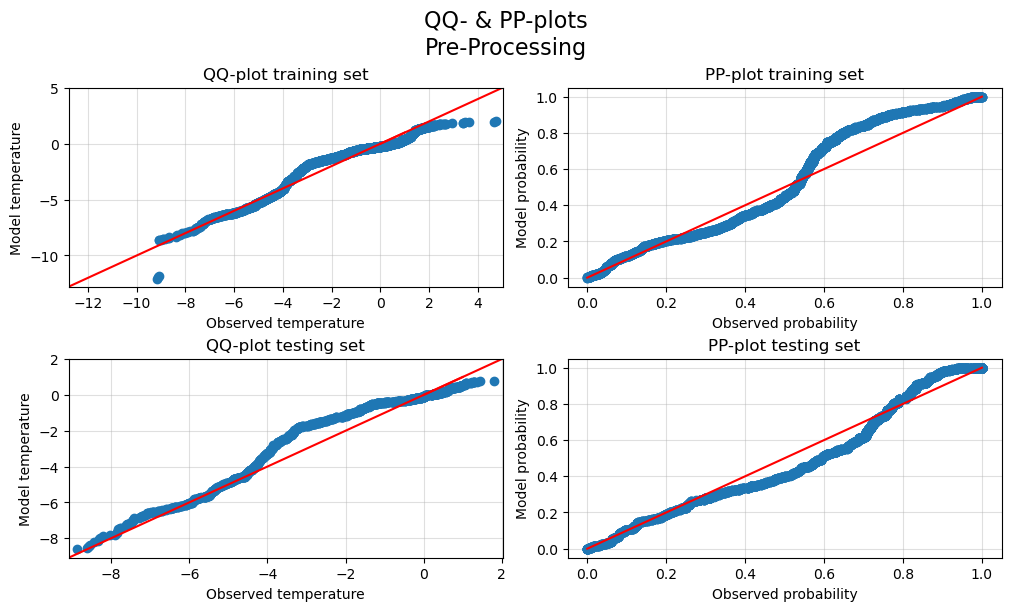

In [107]:
# QQ-plot & PP-plot
data_sets = ['training', 'testing']
# Prep PP-plots
F_train_t1m, F_train_t2m = ECDF(train_df_t1m), ECDF(train_df_t2m)   # Calculate empirical cumulative density functions of empirical data (observed & model)
F_test_t1m, F_test_t2m = ECDF(test_df_t1m), ECDF(test_df_t2m)

x_train = np.sort(np.unique(np.concatenate([train_df_t1m, train_df_t2m])))  # Sort all unique observed & model data of traininig set
x_test = np.sort(np.unique(np.concatenate([train_df_t1m, train_df_t2m])))

p_train_df_t1m, p_train_df_t2m = F_train_t1m(x_train), F_train_t2m(x_train) # Calculate probabilities of sorted values according to empirical CDF
p_test_df_t1m, p_test_df_t2m = F_test_t1m(x_test), F_test_t2m(x_test)

fig, ax = plt.subplots(nrows= len(data_sets), ncols=2, figsize=(10, 6), layout='constrained')   # Prep figure
qqplot_2samples(train_df_t1m, train_df_t2m, line='45', ax=ax[0,0])  # QQ-plots
qqplot_2samples(test_df_t1m, test_df_t2m, line='45', ax=ax[1,0])

ax[0,1].plot(p_train_df_t1m, p_train_df_t2m, 'o', label='PP train') # PP-plots
ax[1,1].plot(p_test_df_t1m, p_test_df_t2m, 'o', label='PP test')

titles=['QQ-plot', 'PP-plot']
for a in range(len(data_sets)):
    title=titles[a]
    for b in range(2):
        ax[b,a].grid(True, alpha=0.4)
        ax[b,a].plot([0,1], [0,1], c='red')
        ax[b,a].set_title(f'{title} {data_sets[b]} set')
        ax[b,0].set_xlabel('Observed temperature')    #The other way around??
        ax[b,0].set_ylabel('Model temperature')
        ax[b,1].set_xlabel('Observed probability')
        ax[b,1].set_ylabel('Model probability')

fig.suptitle('QQ- & PP-plots\nPre-Processing', fontsize=16)
plt.show()

Text(0.5, 0.98, 'Residuals\nPre-Processing')

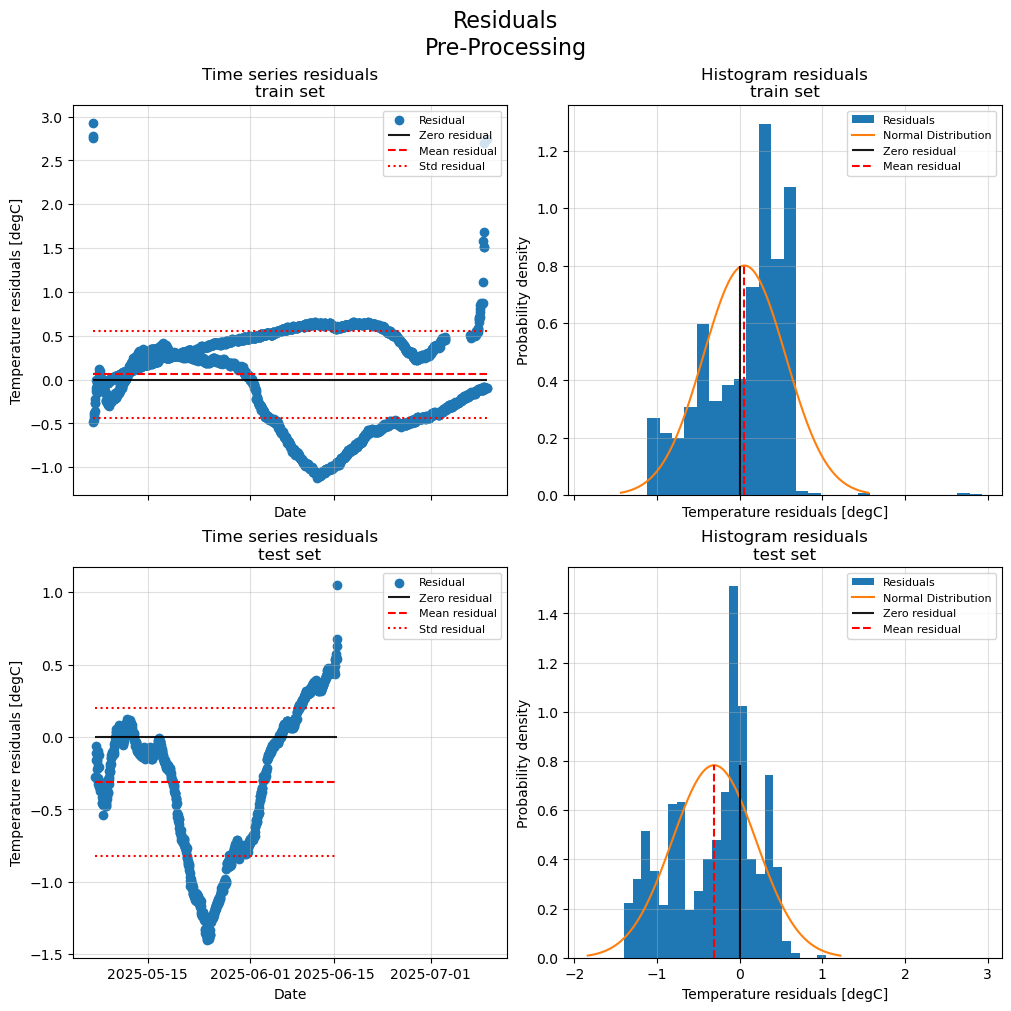

In [81]:
# Residuals Pre-Processing
train_df_res = train_df_t1m - train_df_t2m  # Residulas = Observed - Model
test_df_res = test_df_t1m - test_df_t2m

res_list = [train_df_res, test_df_res]
res_list_names = ['train', 'test']
data_set_list = [train_df, test_df]


fig, ax = plt.subplots(nrows=len(res_list), ncols=2, sharex='col',figsize=(10, 10), layout='constrained')
for res in range(len(res_list)):
    buoy=data_set_list[res].index.get_level_values(0)
    
    ax[res,0].scatter(pd.to_datetime(data_set_list[res].index.get_level_values(-1)), res_list[res], label='Residual')

    ax[res,0].set_title(f'Time series residuals\n{res_list_names[res]} set')
    ax[res,0].set_ylabel('Temperature residuals [degC]')
    ax[res,0].set_xlabel('Date')
    ax[res,0].grid(True, alpha=0.4)
    ax[res,0].hlines(0, (pd.to_datetime(data_set_list[res].index.get_level_values(-1))).min(), 
                     (pd.to_datetime(data_set_list[res].index.get_level_values(-1))).max(), color='black', alpha=0.9, label='Zero residual')
    ax[res,0].hlines(res_list[res].mean(), (pd.to_datetime(data_set_list[res].index.get_level_values(-1))).min(), 
                     (pd.to_datetime(data_set_list[res].index.get_level_values(-1))).max(), color='red', ls='--', label='Mean residual')
    ax[res,0].hlines([res_list[res].mean()-res_list[res].std(),res_list[res].mean()+res_list[res].std()] , 
                     (pd.to_datetime(data_set_list[res].index.get_level_values(-1))).min(), (pd.to_datetime(data_set_list[res].index.get_level_values(-1))).max(), 
                     color='red', ls=':', label='Std residual')

    ax[res,0].legend(loc='upper right', fontsize=8)


    mean, sd, n = res_list[res].mean(), res_list[res].std(), res_list[res].shape[0]
    k = int(1+3.3*np.log(n))
    x=np.linspace(mean-3*sd, mean+3*sd, 100)

    ax[res,1].hist(res_list[res], bins=k, density=True, label='Residuals')
    ax[res,1].plot(x, stats.norm.pdf(x, loc=mean, scale=sd), label='Normal Distribution')

    ax[res,1].grid(True, alpha=0.4)
    ax[res,1].set_title(f'Histogram residuals\n{res_list_names[res]} set')
    ax[res,1].set_ylabel('Probability density')
    ax[res,1].set_xlabel('Temperature residuals [degC]')
    ax[res,1].vlines(0,0,stats.norm.pdf(x, loc=mean, scale=sd).max(), color='black', alpha=0.9, label='Zero residual')
    ax[res,1].vlines(mean, 0, stats.norm.pdf(x, loc=mean, scale=sd).max(), ls='--', color='red', label='Mean residual')
    #ax[res,1].vlines([mean-sd, mean+sd], 0, stats.norm.pdf(x, loc=mean, scale=sd).max(), ls=':', color='red', label='Std residual')

    ax[res,1].legend(loc='upper right', fontsize=8)
fig.suptitle('Residuals\nPre-Processing', fontsize=16)

#### Evaluation Post-processing
- Develop OLS model on train set (buoy 03, 07)
    - OLS model incl. or excl. arome_t2m?
        - incl. arome_t2m makes more sense, since we want to improve the existing predicitions
        - excl. arome_t2m just as exercise for comparison, but doesn't make sense - right(?)

- QQ and PP plots
- Residual plots


In [82]:
# Prepare OLS model on trainig (buoy 03, 07) and test (buoy 10)
train_names= ['KVS_SvalMIZ_03','KVS_SvalMIZ_07']
test_names=['KVS_SvalMIZ_10']

ols_train_df=buoys_df.loc[train_names].dropna() # Training set for OLS model (buoy 03, 07)
ols_test_df=buoys_df.loc[test_names].dropna()   # Test set for OLS model (buoy 10)

dt=(ols_train_df.index.get_level_values(-1))    # Get date and time for train set index
dt=pd.to_datetime(dt)   # Convert date and time from index to datetime
ols_train_df['hour']=dt.hour    # Get the hours 
ols_train_df['doy']=dt.dayofyear    # Get the day of year
ols_train_df = add_cyclic_time(ols_train_df.copy()) #Convert hour and day-of-year to sin() cos() values

dt=(ols_test_df.index.get_level_values(-1)) # Do same date-time conversion for test set as for train set
dt=pd.to_datetime(dt)
ols_test_df['hour']=dt.hour
ols_test_df['doy']=dt.dayofyear
ols_test_df = add_cyclic_time(ols_test_df.copy())

#print(ols_train_df.columns)

In [83]:
# Fit OLS-model on training set (fit1)
# Dependent variable: Observed air temperature
# Independent variables considered: SIC, hour (sin and cos), day-of-year (sin and cos), forecasted air temp AROME
fit1=smf.ols(formula='temp_air ~  sic + hour_cos + hour_sin + day_sin + day_cos + arome_t2m', data=ols_train_df).fit()
rmse_ols1_train=np.sqrt(fit1.mse_resid) # Get the RMSE
alpha=0.05
lower_rmse_ols1_train = np.sqrt(ols_train_df.shape[0]/(stats.chi2.ppf(1-alpha/2,ols_train_df.shape[0])))*rmse_ols1_train
upper_rmse_ols1_train = np.sqrt(ols_train_df.shape[0]/(stats.chi2.ppf(alpha/2,ols_train_df.shape[0])))*rmse_ols1_train

print(f'Training data OLS RMSE: {rmse_ols1_train:.5f}')
print(f'Lower limit: {lower_rmse_ols1_train:.5f}\nUpper limit: {upper_rmse_ols1_train:.5f}')
#print(fit1.params)
#fit1.summary()

Training data OLS RMSE: 1.13014
Lower limit: 1.10196
Upper limit: 1.15980


In [84]:
# Test the OLS-model fit1 on test data set
ols_test_df['pred_ols1'] = fit1.params[0] +fit1.params[1] * ols_test_df['sic'] + fit1.params[2] * ols_test_df['hour_cos'] + \
                            fit1.params[3] * ols_test_df['hour_sin'] + fit1.params[4] * ols_test_df['day_sin'] + \
                            fit1.params[5] * ols_test_df['day_cos'] + fit1.params[6] * ols_test_df['arome_t2m']
alpha=0.05                            
rmse_arome = np.sqrt(((ols_test_df['temp_air'] - ols_test_df['arome_t2m'])**2).mean())
lower_rmse_arome = np.sqrt(ols_test_df.shape[0]/(stats.chi2.ppf(1-alpha/2,ols_test_df.shape[0])))*rmse_arome
upper_rmse_arome = np.sqrt(ols_test_df.shape[0]/(stats.chi2.ppf(alpha/2,ols_test_df.shape[0])))*rmse_arome

rmse_ols1_test = np.sqrt(((ols_test_df['temp_air'] - ols_test_df['pred_ols1'])**2).mean())
lower_rmse_ols1_test =np.sqrt(ols_test_df.shape[0]/(stats.chi2.ppf(1-alpha/2,ols_test_df.shape[0])))*rmse_ols1_test
upper_rmse_ols1_test = np.sqrt(ols_test_df.shape[0]/(stats.chi2.ppf(alpha/2,ols_test_df.shape[0])))*rmse_ols1_test


print(f'Test data OLS RMSE: {rmse_ols1_test:.5f}')
print(f'Lower limit: {lower_rmse_ols1_test:.5f}\nUpper limit: {upper_rmse_ols1_test:.5f}\n')
print(f'RMSE AROME (pre-processing): {rmse_arome:.5f}')
print(f'Lower limit: {lower_rmse_arome:.5f}\nUpper limit: {upper_rmse_arome:.5f}')


Test data OLS RMSE: 1.19389
Lower limit: 1.14287
Upper limit: 1.24971

RMSE AROME (pre-processing): 1.27077
Lower limit: 1.21647
Upper limit: 1.33018


#### Evaluation post-processing
- QQ-plots and PP-plots

In [86]:
# Load data - postprocessing
path_data = "../dataset/"
buoy10_df_post = pd.read_csv(f"{path_data}buoy_10_w_models.csv", index_col=[0, 1])
ols_temp_df = ols_test_df.copy().reset_index(level=0, drop=True)
#ols_temp_df.head()

buoy10_df_post['ols_temp']=ols_temp_df['pred_ols1'].values
buoy10_df_post = buoy10_df_post.reset_index(level=1)

joblib.dump(buoy10_df_post, "buoy10_df_post.joblib")
buoy10_df_post.head()


,lat,lon,arome_t2m,temp_air,temp_surf,temp_snow_ice,temp_ice,sic,residuals,hour,doy,NN_temp,FNN_temp,xgb_temp,xgbdo_temp,xgbpo_temp,ols_temp
2025-05-06 08:00:00,80.859299,6.093521,-6.490082,-6.68750,0.000,-3.81250,-4.8125,0.971986,-0.197418,8,126,-5.564738,-6.684209,-6.313969,-5.635048,-6.172815,-5.440818
2025-05-06 09:00:00,80.861796,6.113147,-6.239807,-6.21875,-3.275,-6.59375,-6.8750,0.971986,0.021057,9,126,-5.297116,-6.286945,-6.219818,-5.384774,-6.840011,-5.138709
2025-05-06 10:00:00,80.863974,6.123736,-5.785614,-5.59375,-2.530,-6.25000,-6.8750,0.971986,0.191864,10,126,-4.774255,-5.721814,-5.237876,-4.930580,-5.464058,-4.677518
2025-05-06 11:00:00,80.866541,6.126697,-5.154785,-5.31250,-2.135,-6.03125,-6.8125,0.973178,-0.157715,11,126,-4.122521,-4.947875,-4.906894,-4.299752,-3.451666,-4.084290
2025-05-06 12:00:00,80.869429,6.125589,-4.690247,-5.00000,-2.070,-5.93750,-6.8125,0.973178,-0.309753,12,126,-3.638842,-4.367708,-4.568455,-3.835213,-3.222568,-3.658359


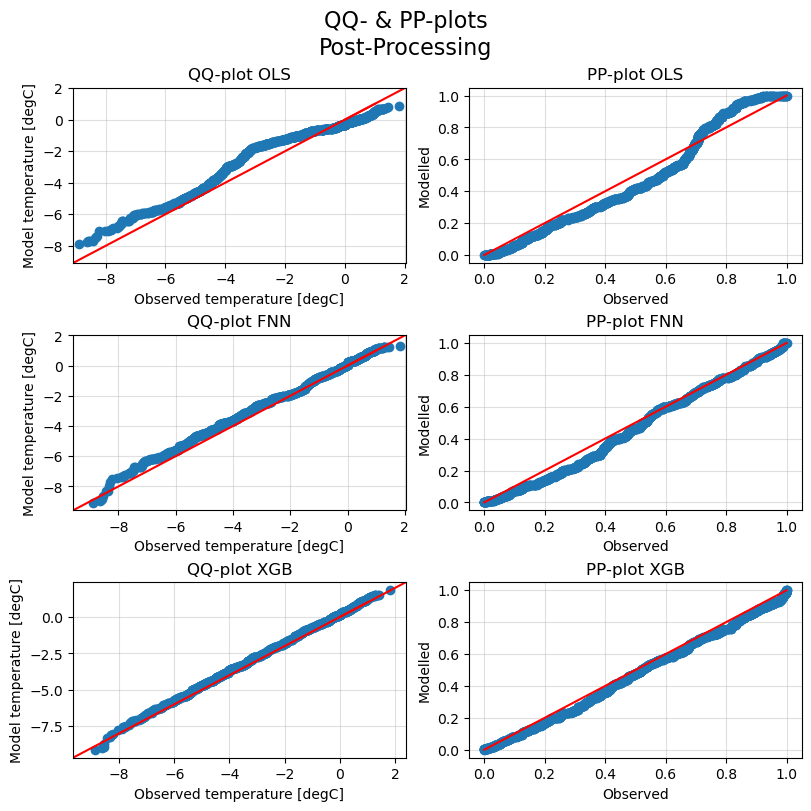

In [108]:
# QQ- & PP-plots Post-processing
temp_post_names=['temp_air', 'ols_temp', 'FNN_temp', 'xgb_temp'] #'arome_t2m',
temp_air, ols_temp, FNN_temp, xgb_temp = [buoy10_df_post[t].to_numpy() for t in temp_post_names] # arome_t2m,
temp_post_list = [temp_air, ols_temp, FNN_temp, xgb_temp] # arome_t2m,
temp_post_list = [np.sort(a) for a in temp_post_list]
temp_post_names=['Observed', 'OLS', 'FNN', 'XGB']

fig, ax = plt.subplots(nrows=len(temp_post_names)-1, ncols=2, figsize=(8,8), layout='constrained')

for a in range(1, len(temp_post_names)):
    # QQ-plot
    qqplot_2samples(temp_post_list[0], temp_post_list[a], line='45', ax=ax[a-1,0])

    # PP-plot
    F_ = ECDF(temp_post_list[a])
    F_0 = ECDF(temp_post_list[0])
    x_=np.sort(np.unique(np.concatenate([temp_post_list[0], temp_post_list[a]])))

    p_=F_(x_)
    p_0=F_0(x_)
    ax[a-1,1].plot(p_0, p_,'o')
    for b in range(2):
        ax[a-1,b].grid(True, alpha=0.4)
        ax[a-1,b].plot([0,1], [0,1],c='red')
        
    ax[a-1,0].set_title(f'QQ-plot {temp_post_names[a]}')
    ax[a-1,0].set_xlabel('Observed temperature [degC]')
    ax[a-1,0].set_ylabel('Model temperature [degC]')

    ax[a-1,1].set_title(f'PP-plot {temp_post_names[a]}')
    ax[a-1,1].set_xlabel('Observed')
    ax[a-1,1].set_ylabel('Modelled')

fig.suptitle('QQ- & PP-plots\nPost-Processing', fontsize=16)
plt.show()

#### Evaluation post-processing
- Residual distribution

Mean residual arome_res: 0.30897

Mean residual ols_res: 0.32485

Mean residual FNN_res: 0.28093

Mean residual xgb_res: 0.24337

Share y- and x-axis? Set Manually??
Normalize STD on sqrt(sample size)??


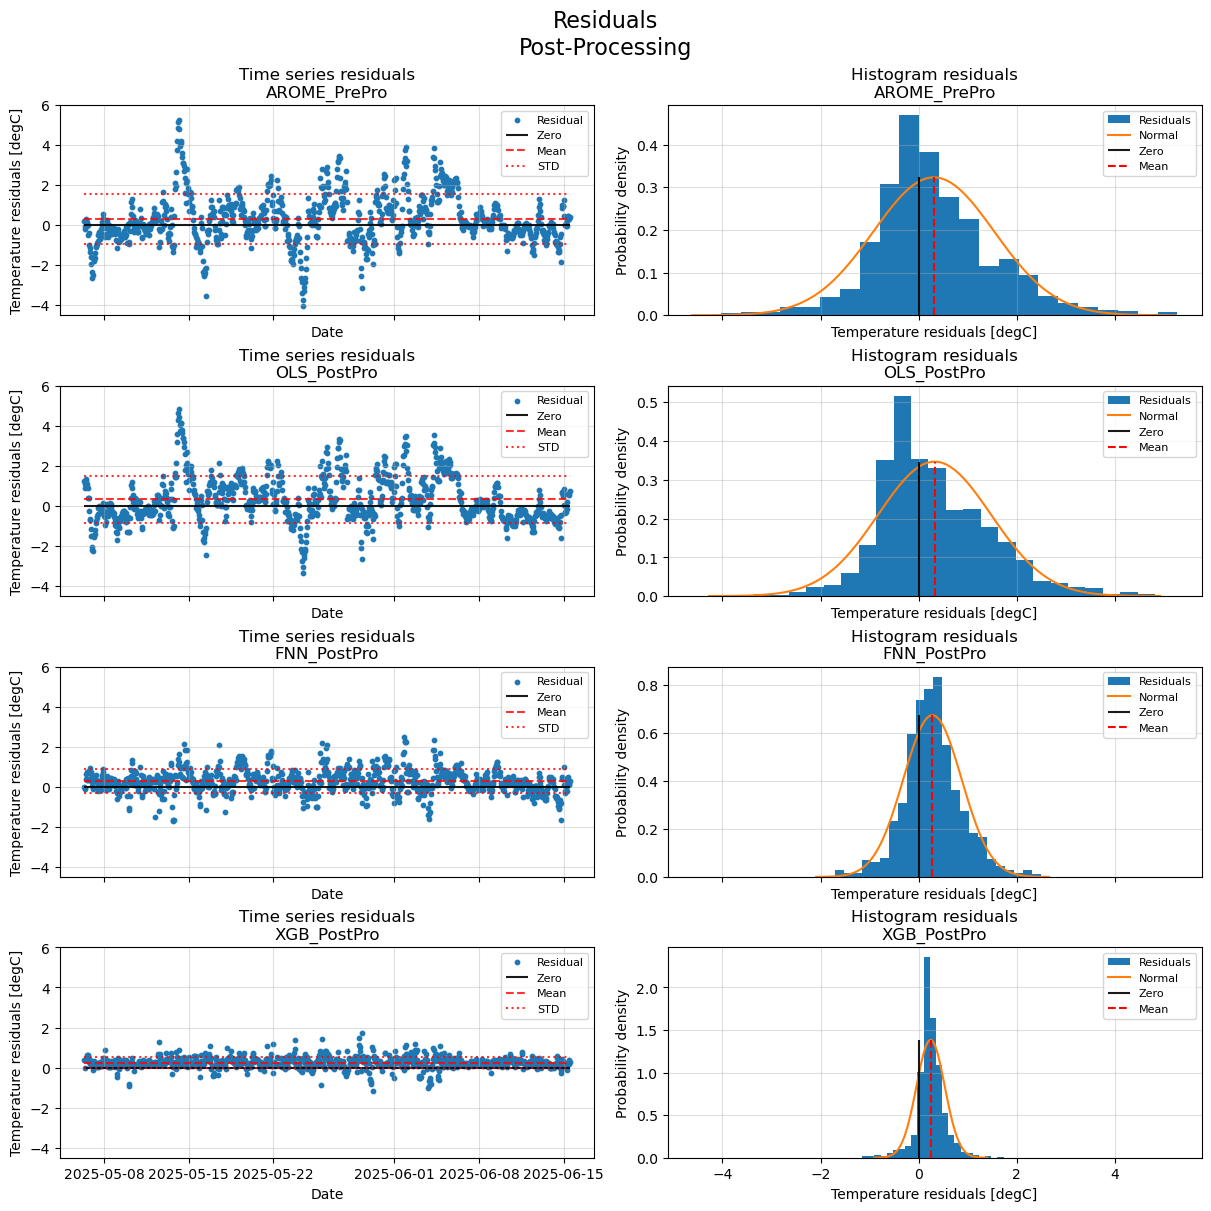

In [106]:
#res_list_names = ['arome_res', 'NN_res', 'FNN_res', 'xgb_res', 'xgbdo_res', 'xgbpo_res', 'ols_res']
#mod_temp_names = ['arome_t2m', 'NN_temp', 'FNN_temp', 'xgb_temp', 'xgbdo_temp', 'xgbpo_temp', 'ols_temp']
#arome_res, NN_res, FNN_res, xgb_res, xgbdo_res, xgbpo_res, ols_res = [buoy10_df_post[t] - buoy10_df_post['temp_air'] for t in mod_temp_names]
res_list_names = ['arome_res', 'ols_res', 'FNN_res', 'xgb_res'] #'arome_res',
processing_names=['AROME_PrePro', 'OLS_PostPro', 'FNN_PostPro', 'XGB_PostPro']
mod_temp_names = ['arome_t2m','ols_temp', 'FNN_temp', 'xgb_temp'] #'arome_t2m', 
arome_res, ols_res, FNN_res, xgb_res = [buoy10_df_post[t] - buoy10_df_post['temp_air'] for t in mod_temp_names] #arome_res

res_list=[arome_res, ols_res, FNN_res, xgb_res]

### AROME IN FOR NOW - SANITY CHECK

fig, ax = plt.subplots(nrows=len(res_list), ncols=2, sharex='col',figsize=(12,12), layout='constrained') #sharex='col', sharey='col',

for res in range(len(res_list)):
    ax[res,0].scatter(pd.to_datetime(buoy10_df_post.index.get_level_values(0)), res_list[res], label='Residual', s=10)
    
    ax[res,0].set_title(f'Time series residuals\n{processing_names[res]}')
    ax[res,0].set_ylabel('Temperature residuals [degC]')
    ax[res,0].set_xlabel('Date')
    ax[res,0].grid(True, alpha=0.4)
    ax[res,0].hlines(0, (pd.to_datetime(buoy10_df_post.index.get_level_values(0))).min(), 
                     (pd.to_datetime(buoy10_df_post.index.get_level_values(0))).max(), color='k',alpha=0.9, label='Zero')
    ax[res,0].hlines(res_list[res].mean(), (pd.to_datetime(buoy10_df_post.index.get_level_values(0))).min(),
                     (pd.to_datetime(buoy10_df_post.index.get_level_values(0))).max(), color='r', ls='--', alpha=0.8, label='Mean')
    ax[res,0].hlines([res_list[res].mean()-res_list[res].std(),res_list[res].mean()+res_list[res].std()],   # NORMALIZE STD on sample size????
                     (pd.to_datetime(buoy10_df_post.index.get_level_values(0))).min(),
                     (pd.to_datetime(buoy10_df_post.index.get_level_values(0))).max(), color='r', ls=':', alpha=0.8, label='STD')
    ax[res,0].legend(loc='upper right', fontsize=8)
    ax[res,0].set_ylim(-4.5,6)

    mean, sd, n = res_list[res].mean(), res_list[res].std(), res_list[res].shape[0]
    print(f'Mean residual {res_list_names[res]}: {mean:.5f}\n')
    k=int(1+3.3*np.log(n))
    x=np.linspace(mean-4*sd, mean+4*sd, 100)
    ax[res,1].hist(res_list[res], bins=k, density=True, label='Residuals')
    ax[res,1].plot(x, stats.norm.pdf(x, loc=mean, scale=sd), label='Normal')

    ax[res,1].grid(True, alpha=0.4)
    ax[res,1].set_title(f'Histogram residuals\n{processing_names[res]}')
    ax[res,1].set_xlabel('Temperature residuals [degC]')
    ax[res,1].set_ylabel('Probability density')
    ax[res,1].vlines(0,0, stats.norm.pdf(x,loc=mean,scale=sd).max(), color='black', alpha=0.9, label='Zero')
    ax[res,1].vlines(mean,0,stats.norm.pdf(x,loc=mean,scale=sd).max(), color='red', ls='--', label='Mean')
    
    ax[res,1].legend(loc='upper right', fontsize=8)

print('Share y- and x-axis? Set Manually??\nNormalize STD on sqrt(sample size)??')
fig.suptitle('Residuals\nPost-Processing', fontsize=16)
plt.show()
